# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)
<br><br>


<div> <b>Цель исследования:</b><br>
    1. Проанализировать поведение клиентов<br>
    2. Спрогнозировать, уйдет ли клиент из банка в ближайшее время<br>
    3. Построить модель с максимально большим значением <b>F1-меры</b>
    <br>
    <b>Ход исследования:</b><br>
    1. Выгрузить таблицу<br>
    2. Изучить признаки<br>
    3. Заменить категориальные признаки<br>
    4. Разделить исходные данные на обучающую, валидационную и тестовую выборки<br>
    5. Построить модели без учета дисбаланса<br>
    6. Построить модели используя upsampling и downsampling<br>
    7. Проверить качество модели на тестовой выборке<br>
</div>

## Подготовка данных
Подключим все необходимые модули

In [1]:
! pip install imblearn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.utils import shuffle
from sklearn.metrics import pairwise
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve 
from imblearn.under_sampling import NearMiss
from tqdm import tqdm

Откроем таблицу

In [3]:
data = pd.read_csv('Churn.csv')
display(data.head())


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Удалим несущественные колонки. Считаю что фамилия не влияет на возможность ухода.

In [4]:
data = data.drop(['RowNumber', 'Surname', 'CustomerId'], axis=1)
display(data.head())

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Посмотрим на не числовые категориальные признаки.

In [5]:
print(data.info())
print(data['Geography']. unique ())
print(data['Gender']. unique ())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           9091 non-null   float64
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB
None
['France' 'Spain' 'Germany']
['Female' 'Male']


Считаю, пустые значения в колонке *Tenure* означают, что клиент новый. Поставлю в пропуски 0.

Применим к *Geography* и *Gender* OHE.

In [6]:
data = data.fillna(0)
data_ohe = pd.get_dummies(data, drop_first=True)

In [7]:
data_ohe['Exited'].mean()

0.2037

Разобьем исходные данные на обучающую, валидационную и тестовую выборки

In [8]:
X = data_ohe.drop('Exited', axis=1)
y = data_ohe['Exited']
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, 
                                                    test_size=0.15, 
                                                    random_state=777,
                                                    stratify = y
                                                  )
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, 
                                                      test_size=0.2, 
                                                      random_state=777,
                                                      stratify = y_train_full
                                                  )
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(6800, 11) (6800,)
(1700, 11) (1700,)
(1500, 11) (1500,)


## Исследование задачи

Построим модель логистической регрессии и посмотрим метрики.

In [9]:
model_reg = LogisticRegression(random_state=777, solver='liblinear', class_weight='balanced')
model_reg.fit(X_train, y_train);

In [10]:
predict = model_reg.predict(X_valid)
print('F1 :', f1_score(predict,y_valid))
print('ROC-AUC:', roc_auc_score(y_valid,model_reg.predict_proba(X_valid)[:,-1]))

F1 : 0.4713870029097963
ROC-AUC: 0.7436070388743266


Качество оставляет желать лучшего.

Проверим лес.

In [11]:
clf = RandomForestClassifier(random_state=777)
parametrs = { 'n_estimators': [10, 30, 90, 150],
              'max_depth': range (5,15)
            }
grid = GridSearchCV(clf, parametrs, scoring='f1', cv=StratifiedKFold(n_splits=5, random_state=777, shuffle=True))
grid.fit(X_train_full, y_train_full)
grid.best_params_

{'max_depth': 13, 'n_estimators': 150}

In [12]:
best_grid_forest = RandomForestClassifier(random_state=777, n_estimators=150 , max_depth=13)
best_grid_forest.fit(X_train, y_train)

RandomForestClassifier(max_depth=13, n_estimators=150, random_state=777)

In [13]:
predict = best_grid_forest.predict(X_valid)
print('F1 :', f1_score(predict,y_valid))
print('ROC-AUC:', roc_auc_score(y_valid,grid.predict_proba(X_valid)[:,-1]))

predict = best_grid_forest.predict(X_train)
print('F1 :', f1_score(predict,y_train))
print('ROC-AUC:', roc_auc_score(y_train,grid.predict_proba(X_train)[:,-1]))

F1 : 0.578096947935368
ROC-AUC: 0.9947767693240325
F1 : 0.8532675709001233
ROC-AUC: 0.9933005990179705


Значения метрик на обучающей выборке намного выше чем на тесте.


Запомним данную модель.

In [14]:
model_forest_clear = RandomForestClassifier(random_state=777, max_depth=13, n_estimators=150)
predict = grid.predict(X_test)
print('F1 :', f1_score(predict,y_test))
print('ROC-AUC:', roc_auc_score(y_test,grid.predict_proba(X_test)[:,-1]))

F1 : 0.5909090909090909
ROC-AUC: 0.8786552588651317


## Борьба с дисбалансом
### Random forest
#### Исследование данных c upsampling

Добавим положительные объекты.

In [15]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=777)
    
    return features_upsampled, target_upsampled
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=777)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=777)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=777)
    
    return features_downsampled, target_downsampled


Построим лес на получившихся данных

In [16]:
def grid_mod(features, target, X_valid, y_valid, method='simple', est=[30, 90, 150, 450], depth=range(5,15,1)):
    best_parameters = {'depth':0,'n_estimators':0, 'max_score':0}
    if method == 'SMOTE':
        oversample = SMOTE(random_state=777, k_neighbors=5)
        X_sampled, y_sampled = oversample.fit_resample(features, target)
    elif method == 'downsample_naive':
        X_sampled, y_sampled = downsample(features, target, 0.4)
    elif method == 'downsample_nm':
        nm = NearMiss(version=2)
        X_sampled, y_sampled = nm.fit_resample(features, target)
    else:
        X_sampled, y_sampled = upsample(features, target, 3)
    for d in tqdm(depth):
        for e in (est):
            model = RandomForestClassifier(random_state=777, n_estimators=e, max_depth=d)
            model.fit(X_sampled, y_sampled)
            predict = model.predict(X_valid)
            if f1_score(y_valid, predict)>best_parameters['max_score']:
                best_parameters['depth'] = d
                best_parameters['n_estimators'] = e
                best_parameters['max_score'] = f1_score(y_valid, predict)
                best_model = model
    print(best_parameters)          
    return best_parameters, best_model
                

In [17]:
grid_mod(X_train, y_train, X_valid, y_valid, method='SMOTE', est=[60, 15, 30, 40], depth=range(5,15))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.28s/it]

{'depth': 12, 'n_estimators': 30, 'max_score': 0.5816733067729083}


({'depth': 12, 'n_estimators': 30, 'max_score': 0.5816733067729083},
 RandomForestClassifier(max_depth=12, n_estimators=30, random_state=777))

In [18]:
grid_mod(X_train, y_train, X_valid, y_valid, est=[60, 15, 30, 40], depth=range(5,15))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.08s/it]

{'depth': 9, 'n_estimators': 40, 'max_score': 0.6295264623955432}


({'depth': 9, 'n_estimators': 40, 'max_score': 0.6295264623955432},
 RandomForestClassifier(max_depth=9, n_estimators=40, random_state=777))

In [19]:
grid_mod(X_train, y_train, X_valid, y_valid, depth=[1,9], est=range(30,70))

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:19<00:00,  9.88s/it]

{'depth': 9, 'n_estimators': 63, 'max_score': 0.6334716459197787}


({'depth': 9, 'n_estimators': 63, 'max_score': 0.6334716459197787},
 RandomForestClassifier(max_depth=9, n_estimators=63, random_state=777))

Запомним лучшие параметры.

In [20]:
model_forest_upsempl = RandomForestClassifier(random_state=777, n_estimators=63, max_depth=9)

In [21]:
X_upsampled, y_upsampled = upsample(X_train, y_train, 3)
model_forest_upsempl.fit(X_upsampled, y_upsampled)
print(f1_score(y_test, model_forest_upsempl.predict(X_test)))
print(f1_score(y_upsampled, model_forest_upsempl.predict(X_upsampled)))
print(roc_auc_score(y_test, model_forest_upsempl.predict_proba(X_test)[:,-1]))
print(roc_auc_score(y_upsampled, model_forest_upsempl.predict_proba(X_upsampled)[:,-1]))

0.6252045826513911
0.8321943811693242
0.8774865613470403
0.9418118543556308


#### Исследование данных c downsampling
Удалим часть отрицательных объектов

In [22]:
grid_mod(X_train, y_train, X_valid, y_valid, method='downsample_naive', est=[30, 90, 150, 450], depth=range(5,15,1));

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.55s/it]

{'depth': 9, 'n_estimators': 150, 'max_score': 0.6158038147138964}


In [38]:
grid_mod(X_train, y_train, X_valid, y_valid, method='downsample_naive', est=range(140, 170), depth=range(8, 10));

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:31<00:00, 15.89s/it]

{'depth': 9, 'n_estimators': 160, 'max_score': 0.616643929058663}


Запомним лучшую модель.

In [39]:
model_forest_downsempl = RandomForestClassifier(random_state=777, n_estimators=160, max_depth=9)

In [25]:
grid_mod(X_train, y_train, X_valid, y_valid, method='downsample_nm');

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.10s/it]

{'depth': 11, 'n_estimators': 90, 'max_score': 0.3615531508593253}


### Логистическая регрессия
Попробуем разные пороги для модели логистической регрессии
#### Исследование данных c upsampling
Добавим положительные объекты и посмотрим как влияют пороги на результат

In [26]:
X_upsampled, y_upsampled = upsample(X_train, y_train, 3)
print(X_upsampled.shape, y_upsampled.shape)

(9570, 11) (9570,)


In [27]:
model = LogisticRegression(random_state=777, solver='liblinear',C=1, class_weight='balanced')
model.fit(X_upsampled, y_upsampled)
probabilities_valid = model.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]
best_score = 0
tr = 0
for threshold in np.arange(0.5, 0.565, 0.001):
    predicted_valid = (model.predict_proba(X_valid)[:,-1]>=threshold)
    F1 = f1_score(y_valid, predicted_valid)
    if F1>best_score:
        best_score = F1
        tr = threshold
print('threshold:', tr, 'F1 :', best_score)

threshold: 0.562 F1 : 0.5036496350364964


In [28]:
predicted_valid = (model.predict_proba(X_valid)[:,-1]>=0.548)
print('ROC-AUC', roc_auc_score(y_valid, model.predict_proba(X_valid)[:,-1]))

ROC-AUC 0.7459571724968196


Значения получились немного лучше чем для стандартного параметра *threshold*.

Проверим отличаются ли значения от несэмплированых данных.

In [29]:
model = LogisticRegression(random_state=777, solver='liblinear',C=0.5, class_weight='balanced')
model.fit(X_train, y_train)
probabilities_valid = model.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]
best_score = 0
tr = 0
for threshold in np.arange(0.50, 0.6, 0.001):
    predicted_valid = (model.predict_proba(X_valid)[:,-1]>=threshold)
    F1 = f1_score(y_valid, predicted_valid)
    if F1>best_score:
        best_score = F1
        tr = threshold
print('threshold:', tr, 'F1 :', best_score)

threshold: 0.558 F1 : 0.5035971223021583


Есть небольшая разница.

Попробуем SMOTE

In [30]:
oversample = SMOTE(random_state=777)
X_upsampled, y_upsampled = oversample.fit_resample(X_train, y_train)

In [31]:

model = LogisticRegression(random_state=777, solver='liblinear', class_weight='balanced')
model.fit(X_upsampled, y_upsampled)
probabilities_valid = model.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]
best_score = 0
tr = 0
for threshold in np.arange(0.50, 0.61, 0.001):
    predicted_valid = (model.predict_proba(X_valid)[:,-1]>=threshold)
    F1 = f1_score(y_valid, predicted_valid)
    if F1>best_score:
        best_score = F1
        tr = threshold
print('threshold:', tr, 'F1 :', best_score)

threshold: 0.544 F1 : 0.49883990719257537


Метрика ухудшилась

In [32]:
predicted_valid = (model.predict_proba(X_valid)[:,-1]>=0.548)
print('ROC-AUC', roc_auc_score(y_valid, model.predict_proba(X_valid)[:,-1]))

ROC-AUC 0.7396282477096336


#### Исследование данных c downsampling
Уберем часть отрицательных объектов и посмотрим как влияют пороги на результат. В данном случае расположение точек в пространстве изменится, ожидаю изменения метрик.

In [33]:
X_downsampled, y_downsampled = downsample(X_train, y_train, 0.4)
print(X_downsampled.shape, y_downsampled.shape)

(3551, 11) (3551,)


In [34]:
model = LogisticRegression(random_state=777, solver='liblinear', class_weight='balanced')
model.fit(X_downsampled, y_downsampled)
probabilities_valid = model.predict_proba(X_valid)
probabilities_one_valid = probabilities_valid[:, 1]
best_score = 0 
tr = 0
for threshold in np.arange(0.5, 0.7, 0.002):
    predicted_valid = (model.predict_proba(X_valid)[:,-1]>=threshold)
    F1 = f1_score(y_valid, predicted_valid)
    if F1>best_score:
        best_score = F1
        tr = threshold
print('threshold:', tr, 'F1 :', best_score)

threshold: 0.544 F1 : 0.4839067702552719


In [35]:
predicted_valid = (model.predict_proba(X_valid)[:,-1]>=0.574)
print('ROC-AUC', roc_auc_score(y_valid, model.predict_proba(X_valid)[:,-1]))

ROC-AUC 0.7268700745382979


"Умное семплирование" делает только хуже

## Тестирование модели
Проверим получившиеся модели на тестовой выборке.
Обучим каждую модель на полной совокупности данных с учетом их сэмплинга.

In [36]:
def roc_auc_plot(y, proba, model):
    fpr, tpr, thresholds = roc_curve(y, proba)
    plt.figure()
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(model)
    

,Score,LR:,LR Train:,RFC,RFC Train,RFU:,RFU Train:,RFD:,RFD Train:
0,F1 :,0.449864,0.581360,0.590909,0.839031,0.612903,0.819807,0.615132,0.803953
1,ROC-AUC:,0.720383,0.728785,0.878655,0.993599,0.875387,0.936819,0.877413,0.942056


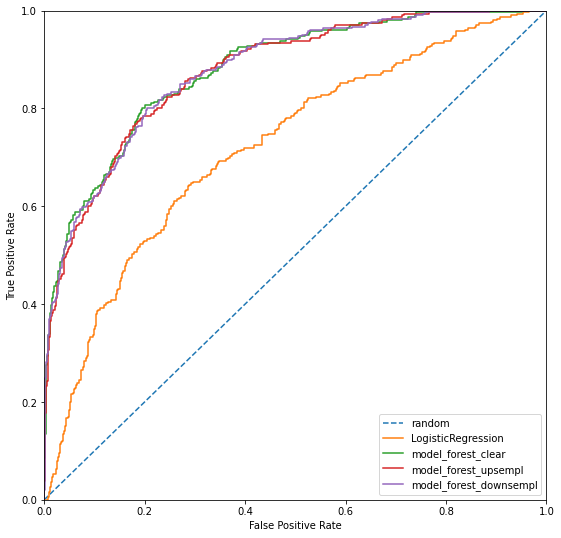

In [40]:
X_full_up, y_full_up = upsample(X_train_full, y_train_full, 3)
X_full_down, y_full_down = downsample(X_train_full, y_train_full, 0.4)

model = LogisticRegression(random_state=777, solver='liblinear', class_weight='balanced')
model.fit(X_full_down, y_full_down)
lg_predicted_valid_test = (model.predict_proba(X_test)[:,-1]>=0.562)
lg_predicted_valid_train = (model.predict_proba(X_full_down)[:,-1]>=0.562)

lg_f1 = f1_score(y_test, lg_predicted_valid_test)
lg_f1_train = f1_score(y_full_down, lg_predicted_valid_train)
lg_roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,-1])
lg_roc_auc_train = roc_auc_score(y_full_down, model.predict_proba(X_full_down)[:,-1])
#roc_auc_plot(y_test, model.predict_proba(X_test)[:,-1], 'LogisticRegression')


model_forest_clear.fit(X_train_full, y_train_full)
rfc_predicted_valid_test = (model_forest_clear.predict_proba(X_test)[:,-1])
rfc_predicted_valid_train = (model_forest_clear.predict_proba(X_train_full)[:,-1])

rfc_f1 = f1_score(y_test, model_forest_clear.predict(X_test))
rfc_f1_train = f1_score(y_train_full, model_forest_clear.predict(X_train_full))
rfc_roc_auc = roc_auc_score(y_test, rfc_predicted_valid_test)
rfc_roc_auc_train = roc_auc_score(y_train_full, rfc_predicted_valid_train)
#roc_auc_plot(y_test, rfc_predicted_valid_test, 'model_forest_clear')


model_forest_upsempl.fit(X_full_up, y_full_up)
rfu_predicted_valid_test = (model_forest_upsempl.predict_proba(X_test)[:,-1])
rfu_predicted_valid_train = (model_forest_upsempl.predict_proba(X_full_up)[:,-1])

rfu_f1 = f1_score(y_test, model_forest_upsempl.predict(X_test))
rfu_f1_train = f1_score(y_full_up, model_forest_upsempl.predict(X_full_up))
rfu_roc_auc = roc_auc_score(y_test, rfu_predicted_valid_test)
rfu_roc_auc_train = roc_auc_score(y_full_up, rfu_predicted_valid_train)
#roc_auc_plot(y_test, rfu_predicted_valid_test, 'model_forest_upsempl')


model_forest_downsempl.fit(X_full_down, y_full_down)
rfd_predicted_valid_test = (model_forest_downsempl.predict_proba(X_test)[:,-1])
rfd_predicted_valid_train = (model_forest_downsempl.predict_proba(X_full_down)[:,-1])

rfd_f1 = f1_score(y_test, model_forest_downsempl.predict(X_test))
rfd_f1_train = f1_score(y_full_down, model_forest_downsempl.predict(X_full_down))
rfd_roc_auc = roc_auc_score(y_test, rfd_predicted_valid_test)
rfd_roc_auc_train = roc_auc_score(y_full_down, rfd_predicted_valid_train)
#roc_auc_plot(y_test, rfd_predicted_valid_test, 'model_forest_downsempl')


table = pd.DataFrame({'Score':['F1 :', 'ROC-AUC:'],
                      'LR:':[lg_f1, lg_roc_auc],
                      'LR Train:':[lg_f1_train, lg_roc_auc_train],
                      'RFC':[rfc_f1,rfc_roc_auc],
                      'RFC Train':[rfc_f1_train,rfc_roc_auc_train],
                      'RFU:':[rfu_f1, rfu_roc_auc],
                      'RFU Train:':[rfu_f1_train, rfu_roc_auc_train],
                      'RFD:':[rfd_f1, rfd_roc_auc],
                      'RFD Train:':[rfd_f1_train, rfd_roc_auc_train]
                     })
display(table)
plt.figure(figsize=(9, 9))
plt.plot([0, 1], [0, 1], linestyle='--')
for i in [model.predict_proba(X_test)[:,-1], rfc_predicted_valid_test, rfu_predicted_valid_test, rfd_predicted_valid_test]:
    fpr, tpr, thresholds = roc_curve(y_test, i)
    plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(('random', 'LogisticRegression', 'model_forest_clear', 'model_forest_upsempl', 'model_forest_downsempl'))
plt.show()


## Вывод
Дана таблица с данными о клиентах банка. Убрали из нее колонки с порядком колонки и с фамилиями клиентов. Заполнили пустые поля в колонке *Tenure* нулями. 

Построили модели логистической регрессии и случайного леса не исправляя дисбаланс. Получили результаты не удовлетворяющие поставленной задаче <b>(F1-мера ниже 0.59)</b>, 0,49 для логистической регрессии и 0,587 для случайного леса. Тем не мение на тестовой выборке случайный лес показал хорошие значения. Скорее всего это случайность.

Построили модели логистической регрессии и случайного леса для данных c *upsampling* и *downsampling*, а также подобрали пороги для регрессии. Обучили лучшие модели на всех данных из обучающей выборки с учетом сэмплинга. Сравнили лучшие модели на тестовой выборке. Лучший результат показал <b>случайный лес с downsampling</b>, эта же модель оказалась менее переобученой, а также показала лучший результат ROC-AUC. 

Все модели оказались переобучены.
